In [6]:
import gzip
from tqdm import tqdm

In [7]:
## if running on colab uncomment this
# from google.colab import drive
# drive.mount('/content/drive')

# %cd "/content/drive/MyDrive/Kuliah/DM/project"

In [8]:
with gzip.open('wikidata5m_all_triplet.txt.gz', 'rb') as f:
  file_content = f.read()

In [9]:
def process_to_list_of_triplets(content):
  triples = content.split('\r\n')
  triples = [tuple(triple.split('\t')) for triple in triples]
  return triples

In [10]:
list_of_triples = process_to_list_of_triplets(file_content.decode("utf-8"))

In [11]:
len(list_of_triples)

21354360

In [12]:
def process_list_of_triples_to_dict(triples):
  result = {}
  for triple in tqdm(triples):
    result[(triple[0], triple[2])] = triple[1]
  return result

In [13]:
list_of_triples[-2]

('Q2485452', 'P31', 'Q34442')

In [14]:
# exclude the last one, not a triple
triples_dict = process_list_of_triples_to_dict(list_of_triples[:-1])

100%|██████████| 21354359/21354359 [00:16<00:00, 1295964.27it/s]


In [15]:
# get degree
def get_degree(triples):
    out_degree_dict = {}
    in_degree_dict = {}
    for triple in tqdm(triples):
        out_degree_dict[triple[0]] = out_degree_dict.get(triple[0], 0) + 1
        in_degree_dict[triple[2]] = in_degree_dict.get(triple[2], 0) + 1
    return out_degree_dict, in_degree_dict

out_dict, in_dict = get_degree(list_of_triples[:-1])

100%|██████████| 21354359/21354359 [00:28<00:00, 749972.02it/s]


In [24]:
out_dict_sorted = dict(sorted(out_dict.items(), key=lambda item: item[1], reverse=True))
in_dict_sorted = dict(sorted(in_dict.items(), key=lambda item: item[1], reverse=True))

print(list(out_dict_sorted.items())[:5])
print(list(in_dict_sorted.items())[:5])

[('Q623', 1368), ('Q12652', 873), ('Q3093', 833), ('Q979470', 692), ('Q2900529', 690)]
[('Q5', 1530721), ('Q30', 817687), ('Q16521', 364147), ('Q7432', 286633), ('Q145', 265383)]


In [25]:
out_dict_sorted

{'Q623': 1368,
 'Q12652': 873,
 'Q3093': 833,
 'Q979470': 692,
 'Q2900529': 690,
 'Q1270623': 689,
 'Q12626': 581,
 'Q12538': 557,
 'Q3105': 555,
 'Q3249': 547,
 'Q12717': 546,
 'Q12589': 533,
 'Q12700': 532,
 'Q12736': 521,
 'Q12753': 520,
 'Q12703': 520,
 'Q3361': 519,
 'Q3372': 518,
 'Q3357': 518,
 'Q12679': 516,
 'Q12722': 515,
 'Q40030': 508,
 'Q2150573': 504,
 'Q12816': 471,
 'Q707051': 456,
 'Q12607': 450,
 'Q707063': 439,
 'Q3083': 433,
 'Q670933': 432,
 'Q23558762': 425,
 'Q40430': 412,
 'Q15499': 409,
 'Q463606': 406,
 'Q314532': 395,
 'Q159': 393,
 'Q30': 383,
 'Q12549': 372,
 'Q1999970': 360,
 'Q12545': 353,
 'Q12569': 345,
 'Q3113': 337,
 'Q451110': 330,
 'Q16287': 329,
 'Q408': 314,
 'Q46130': 308,
 'Q183': 305,
 'Q41115': 295,
 'Q36687': 291,
 'Q1030713': 291,
 'Q148': 279,
 'Q3353': 277,
 'Q12820': 276,
 'Q28003': 273,
 'Q12174': 266,
 'Q865': 265,
 'Q15091': 260,
 'Q16137': 257,
 'Q142': 255,
 'Q41587': 251,
 'Q38': 242,
 'Q649': 242,
 'Q8613': 238,
 'Q3068': 238,
 'Q3

In [28]:
import requests  
from bs4 import BeautifulSoup

def get_name(code):
    if code[0] == 'P':
        url = f"https://www.wikidata.org/wiki/Property:{code}"
    else:
        url = f"https://www.wikidata.org/wiki/{code}"
    
    html = requests.get(url).content
    soup = BeautifulSoup(html, 'html.parser')
    
    title = soup.find_all('span', {'class': 'wikibase-title-label'})
    return title[0].get_text()

get_name("Q1794")

'Frankfurt'

# BFS seperti crawling

In [29]:
from collections import deque
from tqdm import tqdm
import random

def get_subgraph(max_depth: int, start_node: str, triples_list: list, sampling_ratio: float, seed: int, debug: bool = True):
    triples = []
    # adjust the max_depth
    max_depth -= 1
    # tuple of start_node and depth
    queue = deque([(start_node, 0)])
    random.seed(seed)
    
    if debug:
        curr_depth_debug = 0
        print(f"Currently on depth {curr_depth_debug}")
        print(f"Inspecting {len(queue)} child")
        while queue:
            curr_node, curr_depth = queue.popleft()
            if curr_depth != curr_depth_debug:
                curr_depth_debug = curr_depth
                print(f"Currently on depth {curr_depth_debug}")
                print(f"Inspecting {len(queue) + 1} children, sampled by {sampling_ratio}")
            # get adjacent node
            triple_neighbors = [triple for triple in triples_list if triple[0] == curr_node]
            if curr_depth < max_depth:
                # continue doing BFS (continue adding to queue)
                temp_queue = deque([])
                for neighbor in tqdm(triple_neighbors):
                    # all neighbors will be added to list
                    triples.append(neighbor)
                    # however, only several neighbors will continue the BFS iteration
                    temp_queue.append((neighbor[2], curr_depth + 1))
                # sampling
                num_to_sample = int(len(temp_queue) * sampling_ratio)
                sampled_elements = random.sample(temp_queue, num_to_sample)
                queue.extend(sampled_elements)
            else:
                # stop doing BFS (stop adding to queue)
                # sampling again for the last depth
                temp_list = []
                for neighbor in tqdm(triple_neighbors):
                    temp_list.append(neighbor)
                num_to_sample = int(len(temp_list) * sampling_ratio)
                sampled_elements = random.sample(temp_list, num_to_sample)
                triples.extend(sampled_elements)
    else:
        while queue:
            curr_node, curr_depth = queue.popleft()
            # get adjacent node
            triple_neighbors = [triple for triple in triples_list if triple[0] == curr_node]
            if curr_depth < max_depth:
                # continue doing BFS (continue adding to queue)
                temp_queue = deque([])
                for neighbor in triple_neighbors:
                    triples.append(neighbor)
                    temp_queue.append((neighbor[2], curr_depth + 1))
                # sampling
                num_to_sample = int(len(temp_queue) * sampling_ratio)
                sampled_elements = random.sample(temp_queue, num_to_sample)
                queue.extend(sampled_elements)
            else:
                # stop doing BFS (stop adding to queue)
                temp_list = []
                for neighbor in triple_neighbors:
                    temp_list.append(neighbor)
                num_to_sample = int(len(temp_list) * sampling_ratio)
                sampled_elements = random.sample(temp_list, num_to_sample)
                triples.extend(sampled_elements)
    
    return triples    

In [30]:
triples = get_subgraph(3, 'Q1794', list_of_triples, 0.2, 19)

Currently on depth 0
Inspecting 1 child


100%|██████████| 63/63 [00:00<00:00, 62365.15it/s]


Currently on depth 1
Inspecting 12 children, sampled by 0.2


100%|██████████| 206/206 [00:00<?, ?it/s]


Currently on depth 2
Inspecting 96 children, sampled by 0.2


100%|██████████| 11/11 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 32/32 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 18/18 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 28/28 [00:00<?, ?it/s]


In [31]:
len(triples)

1111

In [51]:
print(triples)
dct = process_list_of_triples_to_dict(triples)
print(dct)

[('Q1794', 'P190', 'Q1345'), ('Q1794', 'P17', 'Q27306'), ('Q1794', 'P190', 'Q31487'), ('Q1794', 'P1376', 'Q18285930'), ('Q1794', 'P17', 'Q2415901'), ('Q1794', 'P6', 'Q96981'), ('Q1794', 'P17', 'Q713750'), ('Q1794', 'P150', 'Q315209'), ('Q1794', 'P47', 'Q3042'), ('Q1794', 'P206', 'Q1670'), ('Q1794', 'P31', 'Q1187811'), ('Q1794', 'P47', 'Q7911'), ('Q1794', 'P190', 'Q2079'), ('Q1794', 'P31', 'Q22865'), ('Q1794', 'P190', 'Q456'), ('Q1794', 'P47', 'Q7910'), ('Q1794', 'P190', 'Q16572'), ('Q1794', 'P190', 'Q172'), ('Q1794', 'P190', 'Q1085'), ('Q1794', 'P6', 'Q63882'), ('Q1794', 'P17', 'Q704312'), ('Q1794', 'P30', 'Q46'), ('Q1794', 'P706', 'Q22964'), ('Q1794', 'P190', 'Q205648'), ('Q1794', 'P31', 'Q1066984'), ('Q1794', 'P706', 'Q707278'), ('Q1794', 'P6', 'Q446890'), ('Q1794', 'P190', 'Q490'), ('Q1794', 'P1343', 'Q602358'), ('Q1794', 'P190', 'Q612'), ('Q1794', 'P190', 'Q38283'), ('Q1794', 'P6', 'Q61249'), ('Q1794', 'P190', 'Q1352'), ('Q1794', 'P150', 'Q314199'), ('Q1794', 'P190', 'Q2256'), ('Q1

100%|██████████| 1111/1111 [00:00<00:00, 1095409.44it/s]

{('Q1794', 'Q1345'): 'P190', ('Q1794', 'Q27306'): 'P17', ('Q1794', 'Q31487'): 'P190', ('Q1794', 'Q18285930'): 'P1376', ('Q1794', 'Q2415901'): 'P17', ('Q1794', 'Q96981'): 'P6', ('Q1794', 'Q713750'): 'P17', ('Q1794', 'Q315209'): 'P150', ('Q1794', 'Q3042'): 'P47', ('Q1794', 'Q1670'): 'P206', ('Q1794', 'Q1187811'): 'P31', ('Q1794', 'Q7911'): 'P47', ('Q1794', 'Q2079'): 'P190', ('Q1794', 'Q22865'): 'P31', ('Q1794', 'Q456'): 'P190', ('Q1794', 'Q7910'): 'P47', ('Q1794', 'Q16572'): 'P190', ('Q1794', 'Q172'): 'P190', ('Q1794', 'Q1085'): 'P190', ('Q1794', 'Q63882'): 'P6', ('Q1794', 'Q704312'): 'P17', ('Q1794', 'Q46'): 'P30', ('Q1794', 'Q22964'): 'P706', ('Q1794', 'Q205648'): 'P190', ('Q1794', 'Q1066984'): 'P31', ('Q1794', 'Q707278'): 'P706', ('Q1794', 'Q446890'): 'P6', ('Q1794', 'Q490'): 'P190', ('Q1794', 'Q602358'): 'P1343', ('Q1794', 'Q612'): 'P190', ('Q1794', 'Q38283'): 'P190', ('Q1794', 'Q61249'): 'P6', ('Q1794', 'Q1352'): 'P190', ('Q1794', 'Q314199'): 'P150', ('Q1794', 'Q2256'): 'P190', ('Q1

Gunakan NetworkX

In [38]:
import networkx as nx

In [44]:
G = nx.DiGraph()

for (source, target), label in tqdm(dct.items()):
  G.add_edge(source, target, label=label)

100%|██████████| 1054/1054 [00:00<00:00, 43185.34it/s]


In [47]:
G.number_of_nodes()

836

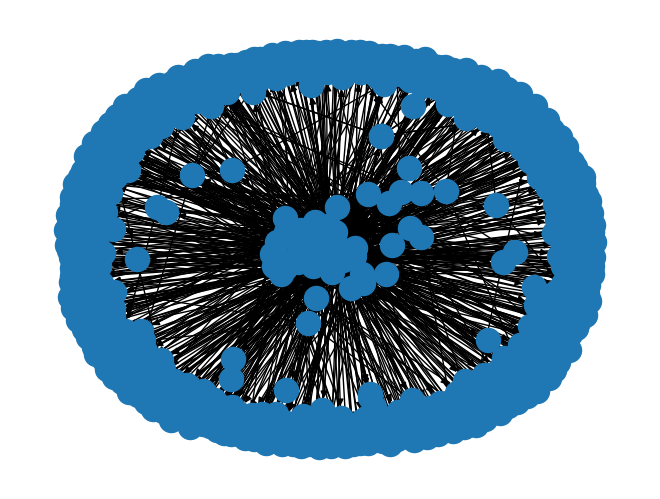

In [48]:
nx.draw(G)

In [52]:
# girvan newman algorithm
# it takes so long to run this, todo: use tqdm to display bar
communities = nx.community.girvan_newman(G)
list_of_communities = list(communities)

In [53]:
len(list_of_communities[1])

3

In [54]:
tmp = []
for st in list_of_communities[1]:
    tmp.append(list(st))

In [55]:
tmp

[['Q84856',
  'Q2618458',
  'Q112675',
  'Q220',
  'Q7910',
  'Q624417',
  'Q38',
  'Q655297',
  'Q253865',
  'Q210720',
  'Q117040',
  'Q96506',
  'Q152115',
  'Q38511',
  'Q430776',
  'Q11725',
  'Q1199215',
  'Q696970',
  'Q315312',
  'Q609134',
  'Q1907114',
  'Q772760',
  'Q515',
  'Q18241891',
  'Q270912',
  'Q1044536',
  'Q2002296',
  'Q2256',
  'Q2807',
  'Q20714',
  'Q54159',
  'Q3130',
  'Q755691',
  'Q543997',
  'Q36036',
  'Q82955',
  'Q3339278',
  'Q704312',
  'Q956',
  'Q14896',
  'Q96981',
  'Q30317',
  'Q600018',
  'Q2054024',
  'Q36405',
  'Q158876',
  'Q185134',
  'Q771260',
  'Q1684642',
  'Q830652',
  'Q926713',
  'Q222964',
  'Q106747',
  'Q273779',
  'Q2899',
  'Q6655',
  'Q2795',
  'Q20230',
  'Q693562',
  'Q1026701',
  'Q8686',
  'Q16552',
  'Q46130',
  'Q3624',
  'Q126670',
  'Q1242250',
  'Q174',
  'Q108679',
  'Q900',
  'Q14159020',
  'Q463',
  'Q3131449',
  'Q16957',
  'Q501303',
  'Q842908',
  'Q13426199',
  'Q1772596',
  'Q478710',
  'Q314199',
  'Q48079',

In [56]:
from pyvis.network import Network

nt = Network('720px', '1280px')
nt.from_nx(G)
nt.repulsion()
# nt.toggle_physics(True)
nt.show('nx.html', notebook=False)

nx.html


In [57]:
colors = ['red', 'blue', 'green', 'yellow', 'orange', 'purple']

for i, community in enumerate(tmp):
    for node in community:
        nt.get_node(node)['color'] = colors[i % len(colors)]

In [58]:
nt.show('nx_girvan.html', notebook=False)

nx_girvan.html


In [59]:
# DUMP
# import pickle

# with open('nxgraph.pickle', 'wb') as handle:
#     pickle.dump(G, handle, -1)

# # with open('nxgraph.pickle', 'rb') as handle:
# #     new_G = pickle.load(handle)

In [60]:
G.number_of_nodes()

836

# ke bawah coba2

In [61]:
# coba girvan newman
import networkx as nx

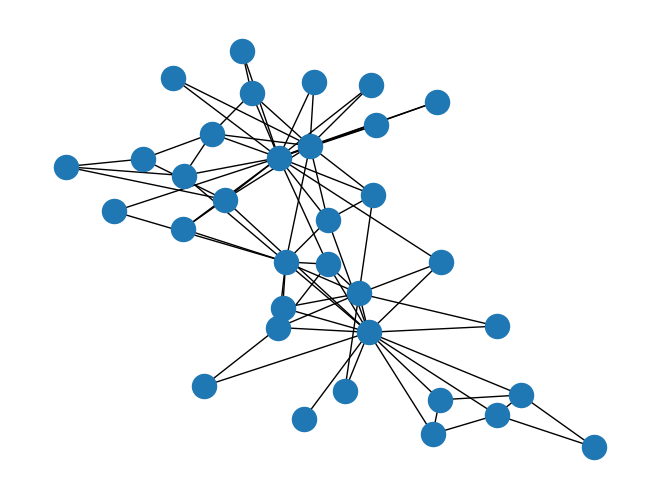

In [62]:
G = nx.karate_club_graph()
nx.draw(G)

In [63]:
comp = nx.community.girvan_newman(G)
tuple(sorted(c) for c in next(comp))

([0, 1, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21],
 [2, 8, 9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33])

In [64]:
import matplotlib.pyplot as plt
import itertools

def draw_communities(G, communities):
    pos = nx.spring_layout(G)  # layout for plotting
    plt.figure(figsize=(10, 7))

    # Generate unique colors for each community
    colors = itertools.cycle(plt.cm.tab20.colors)

    for community in communities:
        color = next(colors)
        nx.draw_networkx_nodes(G, pos, nodelist=community, node_color=[color] * len(community), node_size=300, alpha=0.8)

    nx.draw_networkx_edges(G, pos, alpha=0.5)
    nx.draw_networkx_labels(G, pos, font_size=12)

    plt.show()


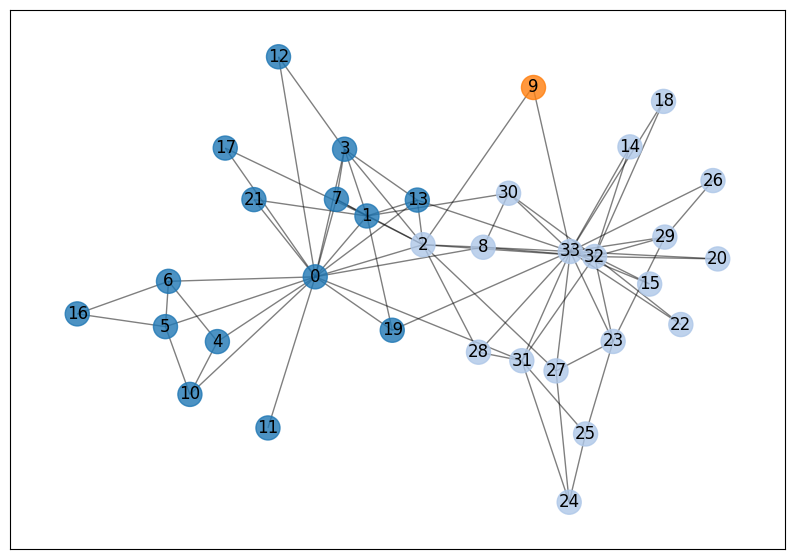

In [65]:
# Get the first set of communities from the generator
communities = next(comp)

    # Convert communities to list of lists
communities = [list(c) for c in communities]

draw_communities(G, communities)

In [66]:
edge_bw = nx.edge_betweenness_centrality(G)
type(edge_bw)

dict

[[0, 1, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21], [2, 8, 9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]]


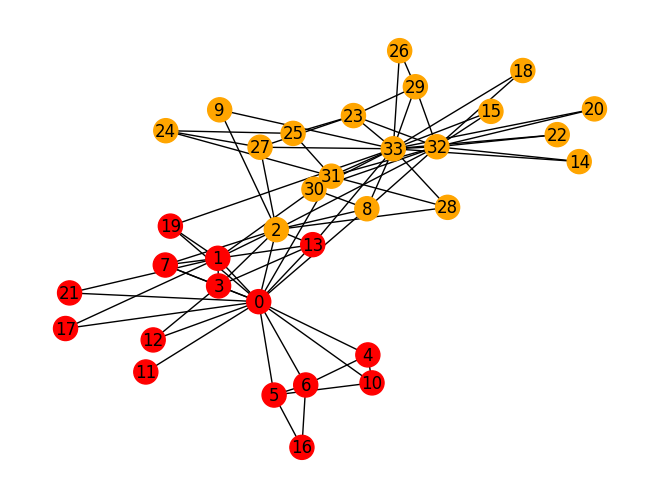

In [67]:
G = nx.karate_club_graph()
communities = nx.community.girvan_newman(G)

node_groups = []
for com in next(communities):
    node_groups.append(list(com))

print(node_groups)

color_map = []
for node in G:
    if node in node_groups[0]:
        color_map.append("red")
    else:
        color_map.append("orange")
nx.draw(G, node_color=color_map, with_labels=True)
plt.show()

In [68]:
components = nx.connected_components(G)
for i, component in enumerate(components):
    print(f"Component {i + 1}: {component}")

Component 1: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33}


{(0, 2): 0.16666666666666669, (0, 1): 0.16666666666666669, (0, 3): 0.13333333333333333, (1, 3): 0.13333333333333333, (1, 4): 0.16666666666666666, (2, 3): 0.13333333333333333, (2, 4): 0.16666666666666666, (3, 4): 0.13333333333333333}
{(0, 1): 0.15000000000000002, (0, 3): 0.25, (1, 3): 0.15000000000000002, (1, 4): 0.2, (2, 3): 0.25, (2, 4): 0.15000000000000002, (3, 4): 0.15000000000000002}
{(0, 1): 0.4, (1, 3): 0.30000000000000004, (1, 4): 0.30000000000000004, (2, 3): 0.2, (2, 4): 0.2, (3, 4): 0.1}


[]

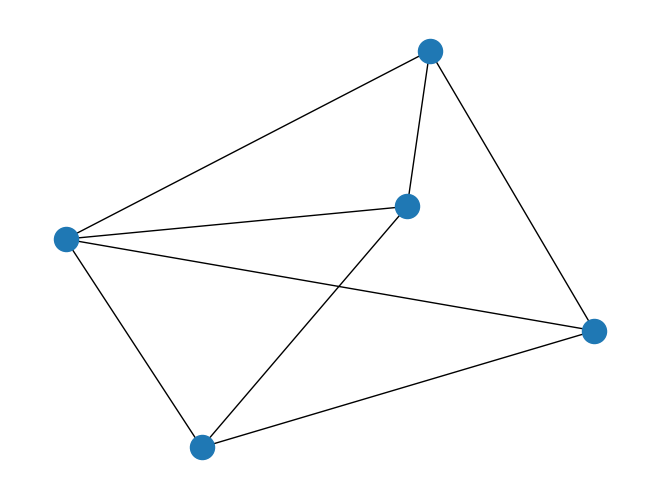

In [69]:
class GirvanNewman(object):
  def __init__(self, G):
    self.__graph = G.copy()

  def __get_edge_betweenness(self):
    return nx.edge_betweenness_centrality(self.__graph)

  def __edge_to_remove(self):
    ebc = self.__get_edge_betweenness()
    print(ebc)
    # get the one with highest edge betweenness centrality
    max_edge = max(ebc, key=ebc.get)
    return max_edge

  def compute(self):
    # get connected components
    cc = nx.connected_components(self.__graph)
    while (len(list(cc)) == 1):
      u, v = self.__edge_to_remove()
      self.__graph.remove_edge(u, v)

      cc = nx.connected_components(self.__graph)

    return cc

# def draw_communities(G, communities):
#     pos = nx.spring_layout(G)
#     plt.figure(figsize=(10, 7))
#     colors = itertools.cycle(plt.cm.tab20.colors)

#     for community in communities:
#         color = next(colors)
#         nx.draw_networkx_nodes(G, pos, nodelist=community, node_color=[color] * len(community), node_size=300, alpha=0.8)

#     nx.draw_networkx_edges(G, pos, alpha=0.5)
#     nx.draw_networkx_labels(G, pos, font_size=12)
#     plt.show()

n = 5  # 10 nodes
m = 8  # 20 edges

G = nx.gnm_random_graph(n, m)
girvan = GirvanNewman(G)
result = girvan.compute()

nx.draw(G)
communities = [list(c) for c in result]
communities

# draw_communities(G, communities)

In [70]:
comp = nx.community.girvan_newman(G)
tuple(sorted(c) for c in next(comp))

([0], [1, 2, 3, 4])